In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [73]:
excel_file = 'V8 data.xlsx'
xls = pd.ExcelFile(excel_file)
sheets_dict = {}
for sheet_name in xls.sheet_names:
    if sheet_name != "_master":  # Skip the "_master" sheet
        sheets_dict[sheet_name] = pd.read_excel(xls, sheet_name=sheet_name)

In [74]:
def parse_weird(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    except ValueError:
        return pd.to_datetime(date_str, format='%m/%d/%y')
    

dfs = []
for table, data in sheets_dict.items():
    if table in ["SPX 500", "china", "fed"]: 
        data["date"] = pd.to_datetime(data["date"], format="%d/%m/%Y")
    elif table in ["Crude", "gold", "SFE"]:
        data["date"] = pd.to_datetime(data["date"], format="%d-%b-%y")
    elif table in ["USD-CNY fx", "GSCI"]: 
        data["date"] = data["date"].apply(parse_weird)
    else: 
        data["date"] = pd.to_datetime(data["date"], format="%d-%b-%Y")

    # rename other columns with prefix
    data = data.rename(columns={c: f"{table}_{c}" for c in data.columns if c != "date"})

    dfs.append(data)


df = dfs[0]
for d in dfs[1:]:
    df = pd.merge(df, d, on="date", how="outer")

df["CHINADAYE_close"] = df["CHINADAYE_close"]*1000

df = df.sort_values("date")
df


,date,Zijin_close,Jiangxi_close,SHFE price_close,SHFE price_volume,LME AL_close,LME AL_volume,LME 3M CU_close,LME 3M CU_volume,SPX 500_close,...,HBM_close,ANTO_close,CAPS_close,LUN_close,MINS_close,MMG_close,CHINADAYE_close,Jinchuan_close,CAML_price,Taseko_close
0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.536356,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,NaN,NaN,NaN,NaN,2077.0,14647.0,7790.0,13734.0,1277.060059,...,10.376892,20.416784,2.928084,4.174498,0.557605,0.375825,59.224926,0.270375,0.903501,2.878623
3,2012-01-04,0.604698,3.427019,8989.370998,2784.0,2065.0,16426.0,7540.0,18056.0,1277.300049,...,10.253877,19.815431,2.904277,4.405809,0.557812,0.370093,57.287778,0.265197,0.905670,2.943791
4,2012-01-05,0.599251,3.367559,8904.511767,2800.0,2036.0,11395.0,7540.0,20240.0,1281.060059,...,10.110817,19.553808,2.863587,4.265961,0.567931,0.373658,54.734890,0.269167,0.905699,2.843974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4173,2024-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4174,2024-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4175,2024-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
cu_ex_1 = pd.read_csv("table_1.csv")
cu_ex_2 = pd.read_csv("table 5.csv")
# cu_ex_3 = pd.read_csv("table_3.csv")
mine_price = pd.read_csv("table_4.csv")


def rename_cme(col: str) -> str:
    if col == "CME Copper Exchange Date":
        return "date"

    variable_name = col[len("CME Copper ") :].lower().strip()
    variable_name = variable_name.replace(" ", "_")
    variable_name = variable_name.replace("%", "perc_")
    return f"cme_{variable_name}"


def rename_shfe(col: str) -> str:
    if col == "SHFE Copper - Exchange Date":
        return "date"

    variable_name = col[len("SHFE Copper ") :].lower().strip()
    variable_name = variable_name.replace(" ", "_")
    variable_name = variable_name.replace("%", "perc_")
    return f"shfe_{variable_name}"



def rename_mining(col: str) -> str:
    if col == "NYSE / NASDAQ Mining Company Date":
        return "date"

    split_col = col.split(" - ")
    stock = split_col[0].lower().strip()
    variable_name = split_col[1].lower().strip()
    variable_name = variable_name.replace(" ", "_")
    variable_name = variable_name.replace("%", "perc_")
    return f"{stock}_{variable_name}"


# Rename columns
cu_ex_1.rename(columns=rename_cme, inplace=True)
cu_ex_2.rename(columns=rename_shfe, inplace=True)
# cu_ex_3.columns = ["date", "lme_value"]
mine_price.rename(columns=rename_mining, inplace=True)

# Convert date columns to datetime
cu_ex_1["date"] = pd.to_datetime(cu_ex_1["date"], format="%d/%m/%y")
cu_ex_2["date"] = pd.to_datetime(cu_ex_2["date"], format="%d-%b-%y")
# cu_ex_3["date"] = pd.to_datetime(cu_ex_3["date"], format="%d/%m/%y")
mine_price["date"] = pd.to_datetime(mine_price["date"], format="%d/%m/%y")

# change percentages to numeric
cu_ex_1["cme_perc_chg"] = (
    cu_ex_1["cme_perc_chg"].str.replace("%", "").astype(float) / 100
)

# cu_ex_3["lme_value"] = cu_ex_3["lme_value"] * 10

# Merge all dataframes
df2 = pd.merge(cu_ex_1, cu_ex_2, on="date", how="outer")
df2 = pd.merge(df2, mine_price, on="date", how="outer")
df2 = df2.sort_values(by="date")

df2.columns

Index(['date', 'cme_close', 'cme_net', 'cme_perc_chg', 'cme_open', 'cme_low',
       'cme_high', 'cme_volume', 'cme_oi', 'cme_bid', 'cme_ask', 'shfe_close',
       'shfe_volume', 'rio_adj_close', 'rio_volume', 'sqm_adj_close',
       'sqm_volume', 'fcx_adj_close', 'fcx_volume', 'bhp_adj_close',
       'bhp_volume', 'nem_adj_close', 'nem_volume', 'scco_adj_close',
       'scco_volume', 'hbm_adj_close', 'hbm_volume', 'ero_adj_close',
       'ero_volume', 'vale_adj_close', 'vale_volume'],
      dtype='object')

In [76]:
df = pd.merge(df,df2,on="date", how="outer")
cols = df.columns.difference(["date"])
df[cols] = df[cols].astype(float)

In [77]:
# # Reusable function to plot all the data (for visual inspection)


# def plot_data(
#     data: pd,
#     figsize: tuple = (14, 3),
#     title: str = "Copper Data",
#     stocks: list = None,
#     exchanges: list = None,
# ):
#     fig, ax = plt.subplots(1, 4, figsize=figsize)

#     exchanges = exchanges or ["cme", "shfe", "lme"]
#     stocks = stocks or ["rio", "sqm", "fcx", "bhp", "nem", "scco", "hbm", "ero", "vale"]

#     # if "lme" in exchanges:
#     #     ax[2].plot(data["date"], data["lme_CU_close"], label="LME Copper Value")
#     #     ax[2].set_title("LME Copper Exchange")
#     #     exchanges.remove("lme")

#     for i, exch in enumerate(exchanges):
#         ax[i].plot(data["date"], data[f"{exch}_high"], label=f"high")
#         ax[i].plot(data["date"], data[f"{exch}_low"], label=f"low")
#         ax[i].plot(data["date"], data[f"{exch}_open"], label=f"open")
#         ax[i].plot(data["date"], data[f"{exch}_close"], label=f"close")
#         ax[i].set_title(f"{exch.upper()} Copper Exchange")

#     for i, stock in enumerate(stocks):
#         ax[3].plot(
#             data["date"], data[f"{stock}_adj_close"], label=f"{stock.upper()} Close"
#         )

#     ax[3].set_title("Mining Companies")

#     plt.tight_layout()
#     plt.suptitle(title)
#     plt.show()


# plot_data(df, title="Copper Data")

In [78]:
# Now lets reindex the data and interpolate the missing values

date_range = pd.date_range(start=df["date"].min(), end="2024-07-31", freq="D")
df_reindexed = (
    df.set_index("date")
    .reindex(date_range)
    .reset_index()
    .rename(columns={"index": "date"})
)
df_interpolated = df_reindexed.interpolate(method='linear')
df_final = df_interpolated.ffill().bfill()

# plot_data(df_final, title="Copper Data", figsize=(14, 3), stocks=["rio", "sqm"])
df_final.columns

Index(['date', 'Zijin_close', 'Jiangxi_close', 'SHFE price_close',
       'SHFE price_volume', 'LME AL_close', 'LME AL_volume', 'LME 3M CU_close',
       'LME 3M CU_volume', 'SPX 500_close', 'SPX 500_volume', 'Crude_close',
       'Crude_volume', 'gold_close', 'gold_volume', 'china_rate', 'Fed_rate',
       'USD-CNY fx_Close', 'GSCI_close', 'Clean_close', 'EQIX_close',
       'ETN_close', 'EMR_close', 'TSLA_close', 'BYD_close', 'SFR_close',
       'Glen_close', 'CMOC_close', 'BAO_close', 'IVAN_close', 'FQM_close',
       'HBM_close', 'ANTO_close', 'CAPS_close', 'LUN_close', 'MINS_close',
       'MMG_close', 'CHINADAYE_close', 'Jinchuan_close', 'CAML_price',
       'Taseko_close', 'cme_close', 'cme_net', 'cme_perc_chg', 'cme_open',
       'cme_low', 'cme_high', 'cme_volume', 'cme_oi', 'cme_bid', 'cme_ask',
       'shfe_close', 'shfe_volume', 'rio_adj_close', 'rio_volume',
       'sqm_adj_close', 'sqm_volume', 'fcx_adj_close', 'fcx_volume',
       'bhp_adj_close', 'bhp_volume', 'nem_adj_

In [79]:
# Finally let us write out this new data to a csv file
df_final.to_csv("copper_data.csv")

In [80]:
# Regression for relationship between CME copper and FCX stock price - trained on 98% of the data to predict the last 2%
split = int(0.80 * len(df_final))
train = df_final[:split]
test = df_final[split:] 


In [81]:
def linear_regression(train, test, x_col, y_col):
    
    X = sm.add_constant(train[x_col])
    model = sm.OLS(train[y_col], X).fit()
    print(model.summary())
    return model.predict(sm.add_constant(test[x_col]))


def plot_linear_regression(train, test, x_col, y_col, y_pred):
    x_lab = x_col.split("_")[0].upper()
    y_lab = y_col.split("_")[0].upper()
    plt.plot(df_final["date"], df_final[x_col], label=f"{x_lab} Share price")
    plt.plot(train["date"], train[y_col], label=f"{y_lab} Share Price ($/lb)")
    plt.plot(test["date"], test[y_col], label=f"Actual {y_lab} Price ($/lb)")
    plt.plot(test["date"], y_pred, label=f"{y_lab} Price ($/lb) Prediction")
    plt.xlabel("Date")  # Add x-axis label
    plt.ylabel("Price in USD")  # Add y-axis label

    # plt.plot(test[x_col], y_pred, label="Prediction")
    plt.legend()
    plt.show()
    


def calculate_mean_absolute_percentage_error(data, y_col, y_pred):
    return (
        ((y_pred - data[y_col]) / data[y_col])
        .abs()
        .mean()
        .item()
    )


                            OLS Regression Results                            
Dep. Variable:              cme_close   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:00:20   Log-Likelihood:                -493.74
No. Observations:                3676   AIC:                             991.5
Df Residuals:                    3674   BIC:                             1004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.9269      0.010    184.768

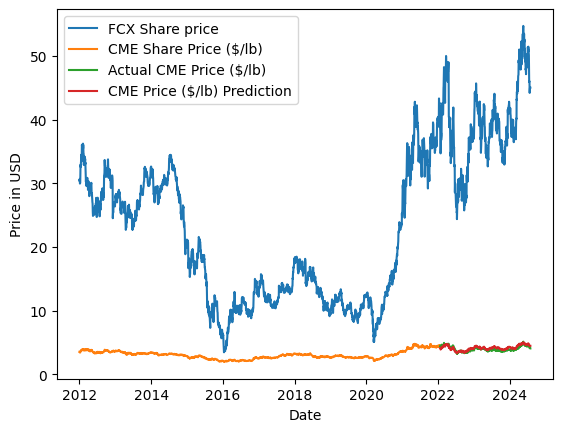

0.05790013192267696

In [82]:

y_pred = linear_regression(train, test, "fcx_adj_close", "cme_close")

plot_linear_regression(train, test, "fcx_adj_close", "cme_close", y_pred)

calculate_mean_absolute_percentage_error(test, "cme_close", y_pred)

                            OLS Regression Results                            
Dep. Variable:          bhp_adj_close   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     7583.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:00:20   Log-Likelihood:                -11714.
No. Observations:                3676   AIC:                         2.343e+04
Df Residuals:                    3674   BIC:                         2.344e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.7408      0.493    -15.709      0.0

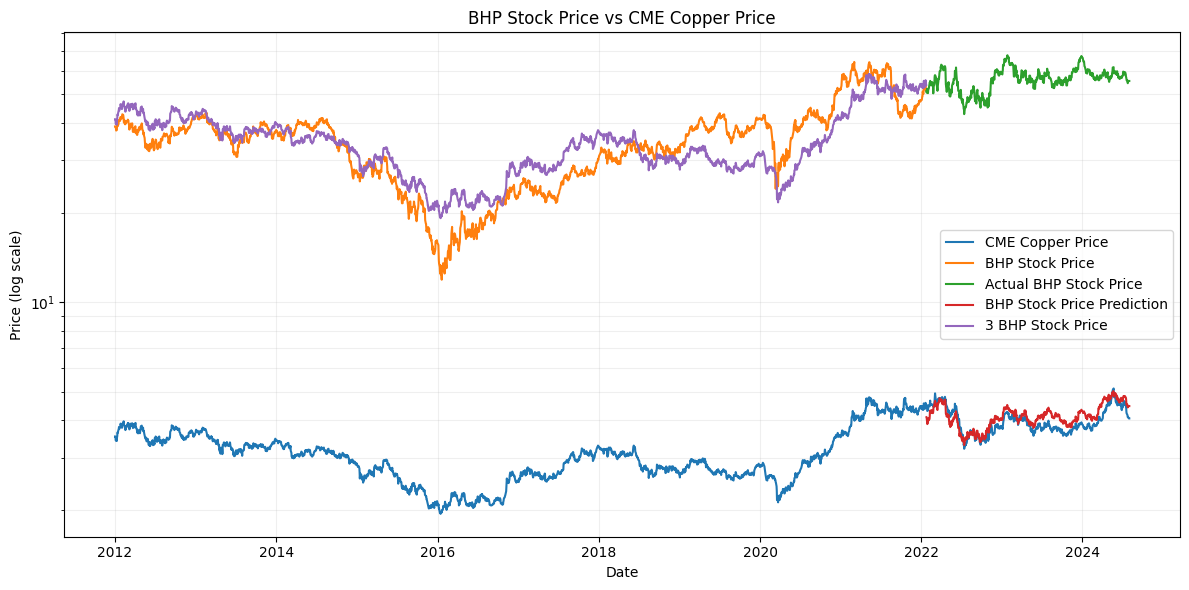

0.9262169798597352

In [83]:
X = sm.add_constant(train["cme_close"])
model = sm.OLS(train["bhp_adj_close"], X).fit()
print(model.summary())
f_pred = model.predict(sm.add_constant(train["cme_close"]))

plt.figure(figsize=(12, 6))

plt.semilogy(df_final["date"], df_final["cme_close"], label=f"CME Copper Price")
plt.semilogy(train["date"], train["bhp_adj_close"], label=f"BHP Stock Price")
plt.semilogy(test["date"], test["bhp_adj_close"], label=f"Actual BHP Stock Price")
plt.semilogy(test["date"], y_pred, label=f"BHP Stock Price Prediction")
plt.semilogy(train["date"], f_pred, label=f"3 BHP Stock Price")

plt.xlabel("Date")
plt.ylabel("Price (log scale)")
plt.title(f"BHP Stock Price vs CME Copper Price")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

calculate_mean_absolute_percentage_error(test, "bhp_adj_close", y_pred)

In [84]:
summary = []
for ex_id in ["shfe_close", "cme_close", "LME 3M CU_close"]:
  for stock_id in ["scco_adj_close", "vale_adj_close", "Zijin_close",	"Jiangxi_close", "SFR_close", "Glen_close", "rio_adj_close", "fcx_adj_close", "bhp_adj_close", "nem_adj_close", "hbm_adj_close", "ero_adj_close", "CMOC_close", "BAO_close", "IVAN_close", "FQM_close", "ANTO_close", "CAPS_close", "LUN_close", "MINS_close", "MMG_close", "CHINADAYE_close", "Jinchuan_close", "CAML_price", "Taseko_close"]:
       
      y_pred = linear_regression(train, test, ex_id, stock_id)
      mape = calculate_mean_absolute_percentage_error(test, stock_id, y_pred)
      summary.append({"ex_id": ex_id, "stock_id": stock_id, "mape": mape})

reg_df_1 = pd.DataFrame(summary)
reg_df_1.to_clipboard()

                            OLS Regression Results                            
Dep. Variable:         scco_adj_close   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     2204.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:00:20   Log-Likelihood:                -13380.
No. Observations:                3676   AIC:                         2.676e+04
Df Residuals:                    3674   BIC:                         2.678e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0587      0.826    -10.971      0.0

In [85]:
#multi variable linear regression 
def mv_regression(train, test, x_cols, y_col):
    # Reset indices to avoid any potential indexing issues
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    # Print column names and check for consistency


    # Add constant and check shapes
    X = sm.add_constant(train[x_cols])

    # Ensure no NaNs

    model = sm.OLS(train[y_col], X).fit()
    print(model.summary())

    # Prepare test data
    x_test = sm.add_constant(test[x_cols])


      # Check if X and x_test have the same number of columns
    if X.shape[1] != x_test.shape[1]:
        raise ValueError("Mismatch in the number of columns between train and test data")

    predictions = model.predict(x_test)
    print(f"Predictions shape: {predictions.shape}")

    return model, predictions


In [104]:
summary = []
models = []
Xs = ["SHFE price_close", "LME 3M CU_close", "cme_close"]

for stock_id in ["scco_adj_close", "vale_adj_close", "Zijin_close", "Jiangxi_close", "SFR_close", "Glen_close", "rio_adj_close", "fcx_adj_close", "bhp_adj_close", "nem_adj_close", "hbm_adj_close", "ero_adj_close", "CMOC_close", "BAO_close", "IVAN_close", "FQM_close", "ANTO_close", "CAPS_close", "LUN_close", "MINS_close", "MMG_close", "CHINADAYE_close", "Jinchuan_close", "CAML_price", "Taseko_close"]:
    

    model, y_pred = mv_regression(train, test, Xs, stock_id)
    mape = ((test [stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id]).abs().mean().item()
    mpe = ((test [stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id]).mean().item()


    omnibus_test = sm.stats.omni_normtest(model.resid)
    jb_test = sm.stats.jarque_bera(model.resid)

    summary.append({
        "stock_id": stock_id,
        "MAPE": mape,
        'R2': model.rsquared,
        'P_value': model.f_pvalue,
        'F_stat': model.fvalue,
        'Skew': model.resid.skew(),
        'Kurtosis': model.resid.kurtosis(),
        'Durbin_Watson': sm.stats.durbin_watson(model.resid),
        'Omnibus': omnibus_test[0],  # Omnibus test statistic
        'Omnibus_pvalue': omnibus_test[1],  # p-value for the Omnibus test
        'Jarque_Bera': jb_test[0],  # Jarque-Bera test statistic
        'Jarque_Bera_pvalue': jb_test[1],  # p-value for the Jarque-Bera test
        'MPE': mpe
    })

reg_df_1 = pd.DataFrame(summary)
reg_df_1.to_clipboard()
reg_df_1 


                            OLS Regression Results                            
Dep. Variable:         scco_adj_close   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     1117.
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:31:56   Log-Likelihood:                -13052.
No. Observations:                3676   AIC:                         2.611e+04
Df Residuals:                    3672   BIC:                         2.614e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.4249      0.857  

,stock_id,MAPE,R2,P_value,F_stat,Skew,Kurtosis,Durbin_Watson,Omnibus,Omnibus_pvalue,Jarque_Bera,Jarque_Bera_pvalue,MPE
0,scco_adj_close,0.356740,0.477136,0.000000e+00,1116.953614,-0.295524,0.920128,0.051110,115.901357,6.797358e-26,182.328415,2.557924e-40,0.356493
1,vale_adj_close,0.107978,0.838992,0.000000e+00,6378.116079,0.082169,0.299742,0.164890,14.949884,5.671186e-04,17.707873,1.428184e-04,0.012624
2,Zijin_close,0.322271,0.500926,0.000000e+00,1228.543994,0.467602,0.066283,0.040921,122.606832,2.378289e-27,134.489666,6.250866e-30,0.322271
3,Jiangxi_close,0.279896,0.563162,0.000000e+00,1577.956667,0.712423,1.159446,0.012761,343.480801,2.594727e-75,515.469388,1.167467e-112,-0.279896
4,SFR_close,0.423851,0.310458,1.067589e-295,551.090912,0.622302,0.607348,0.020302,237.294782,2.965465e-52,293.109752,2.249190e-64,-0.400879
5,Glen_close,0.246916,0.518279,0.000000e+00,1316.888106,-0.535843,-0.611824,0.036480,281.268858,8.379991e-62,233.254767,2.235480e-51,0.245260
6,rio_adj_close,0.232445,0.535376,0.000000e+00,1410.390342,-0.433229,0.747257,0.096152,153.542141,4.557721e-34,199.818230,4.074015e-44,0.232224
7,fcx_adj_close,0.202508,0.832589,0.000000e+00,6087.327328,0.445930,0.685791,0.080354,153.566566,4.502399e-34,193.229781,1.098212e-42,0.197573
8,bhp_adj_close,0.124507,0.739223,0.000000e+00,3469.669170,0.035510,-0.506411,0.101765,73.181403,1.284873e-16,40.198340,1.866557e-09,0.106423
9,nem_adj_close,0.235906,0.541832,0.000000e+00,1447.507918,0.723587,0.975973,0.169551,331.602784,9.848506e-73,465.528485,8.161576e-102,-0.131217


In [105]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def mv_regression(train, test, Xs, y):
    X_train = sm.add_constant(train[Xs])
    y_train = train[y]
    
    model = sm.OLS(y_train, X_train).fit()
    
    X_test = sm.add_constant(test[Xs])
    y_pred = model.predict(X_test)
    
    return model, y_pred

# List of stock IDs
stock_ids = ["scco_adj_close", "vale_adj_close", "Zijin_close", "Jiangxi_close", "SFR_close", "Glen_close", "rio_adj_close", "fcx_adj_close", "bhp_adj_close", "nem_adj_close", "hbm_adj_close", "ero_adj_close", "CMOC_close", "BAO_close", "IVAN_close", "FQM_close", "ANTO_close", "CAPS_close", "LUN_close", "MINS_close", "MMG_close", "CHINADAYE_close", "Jinchuan_close", "CAML_price", "Taseko_close"]

# Aggregate the mining companies
train['aggregated_mining'] = train[stock_ids].mean(axis=1)
test['aggregated_mining'] = test[stock_ids].mean(axis=1)

Xs = ["SHFE price_close", "LME 3M CU_close", "cme_close"]

# Perform regression on aggregated data
model, y_pred = mv_regression(train, test, Xs, 'aggregated_mining')

# Calculate metrics
mape = np.abs((test['aggregated_mining'].to_numpy() - y_pred.to_numpy()) / test['aggregated_mining']).mean()
mpe = ((test['aggregated_mining'].to_numpy() - y_pred.to_numpy()) / test['aggregated_mining']).mean()

omnibus_test = sm.stats.omni_normtest(model.resid)
jb_test = sm.stats.jarque_bera(model.resid)

# Create summary dictionary
summary = {
    "MAPE": mape,
    'R2': model.rsquared,
    'P_value': model.f_pvalue,
    'F_stat': model.fvalue,
    'Skew': model.resid.skew(),
    'Kurtosis': model.resid.kurtosis(),
    'Durbin_Watson': sm.stats.durbin_watson(model.resid),
    'Omnibus': omnibus_test[0],  # Omnibus test statistic
    'Omnibus_pvalue': omnibus_test[1],  # p-value for the Omnibus test
    'Jarque_Bera': jb_test[0],  # Jarque-Bera test statistic
    'Jarque_Bera_pvalue': jb_test[1],  # p-value for the Jarque-Bera test
    'MPE': mpe
}

# Create DataFrame from summary
reg_df = pd.DataFrame([summary])

# Copy to clipboard and display results
reg_df.to_clipboard()
print(reg_df)

# Display model summary
print(model.summary())

       MAPE        R2  P_value       F_stat      Skew  Kurtosis  \
0  0.179623  0.855164      0.0  7226.950058 -0.623783 -0.169378   

   Durbin_Watson     Omnibus  Omnibus_pvalue  Jarque_Bera  Jarque_Bera_pvalue  \
0       0.026696  208.552418    5.169134e-46    242.66447        2.023391e-53   

        MPE  
0  0.178611  
                            OLS Regression Results                            
Dep. Variable:      aggregated_mining   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     7227.
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:06:05   Log-Likelihood:                -7678.4
No. Observations:                3676   AIC:                         1.536e+04
Df Residuals:                    3672   BIC:                         1.539e+04
Df Model:                           3     

C:\Users\jongi\AppData\Local\Temp\ipykernel_33148\1349416951.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['aggregated_mining'] = train[stock_ids].mean(axis=1)
C:\Users\jongi\AppData\Local\Temp\ipykernel_33148\1349416951.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['aggregated_mining'] = test[stock_ids].mean(axis=1)


                            OLS Regression Results                            
Dep. Variable:             ANTO_close   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 2.124e+04
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:00:21   Log-Likelihood:                -7146.3
No. Observations:                3676   AIC:                         1.430e+04
Df Residuals:                    3674   BIC:                         1.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4745      0.151    -55.938      0.0

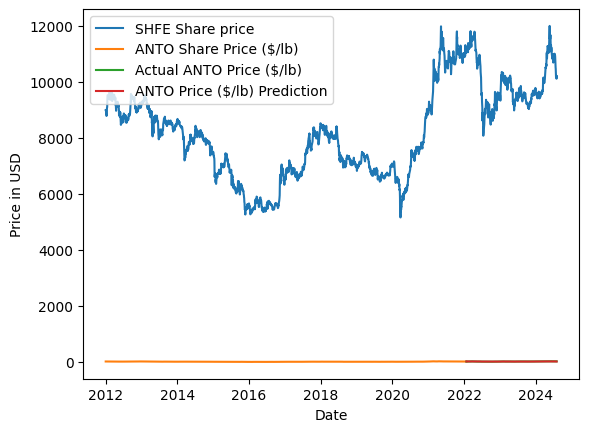

0.13030571667513632

In [87]:
y_pred = linear_regression(train, test, "shfe_close", "ANTO_close")

plot_linear_regression(train, test, "shfe_close", "ANTO_close", y_pred)

calculate_mean_absolute_percentage_error(test, "ANTO_close", y_pred)

#new

In [88]:
summary = []
models = []
Xs = ["scco_adj_close", "vale_adj_close", "Zijin_close", "Jiangxi_close", "SFR_close", "Glen_close", "rio_adj_close", "fcx_adj_close", "bhp_adj_close", "nem_adj_close", "hbm_adj_close", "ero_adj_close", "CMOC_close", "BAO_close", "IVAN_close", "FQM_close", "ANTO_close", "CAPS_close", "LUN_close", "MINS_close", "MMG_close", "CHINADAYE_close", "Jinchuan_close", "CAML_price", "Taseko_close"]

for stock_id in ["LME 3M CU_close", "cme_close", "shfe_close"]:
    

    model, y_pred = mv_regression(train, test, Xs, stock_id)
    mape = ((test [stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id]).abs().mean().item()
    mpe = ((test [stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id]).mean().item()


    omnibus_test = sm.stats.omni_normtest(model.resid)
    jb_test = sm.stats.jarque_bera(model.resid)

    summary.append({
        "stock_id": stock_id,
        "MAPE": mape,
        'MPE': mpe
    })

reg_df_1 = pd.DataFrame(summary)
reg_df_1.to_clipboard()
reg_df_1 

                            OLS Regression Results                            
Dep. Variable:        LME 3M CU_close   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     8201.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:00:21   Log-Likelihood:                -24177.
No. Observations:                3676   AIC:                         4.841e+04
Df Residuals:                    3650   BIC:                         4.857e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3054.8539     46.073     

,stock_id,MAPE,MPE
0,LME 3M CU_close,0.156370,-0.150253
1,cme_close,0.155142,-0.147917
2,shfe_close,0.163443,-0.153127


In [89]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def combine_data(df, exchange_columns, stock_columns):
    # Combine exchange data
    exchanges = df[exchange_columns].sum(axis=1)
    
    # Combine stock data
    stocks = df[stock_columns].mean(axis=1)
    
    return pd.DataFrame({'exchanges': exchanges, 'stocks': stocks})

def perform_regression(train, test):
    model = LinearRegression()
    model.fit(train[['exchanges']], train['stocks'])
    
    y_pred_train = model.predict(train[['exchanges']])
    y_pred_test = model.predict(test[['exchanges']])
    
    mape_train = np.mean(np.abs((train['stocks'] - y_pred_train) / train['stocks'])) * 100
    mape_test = np.mean(np.abs((test['stocks'] - y_pred_test) / test['stocks'])) * 100
    
    return {
        'Intercept': model.intercept_,
        'Coefficient': model.coef_[0],
        'MAPE (Train)': mape_train,
        'MAPE (Test)': mape_test
    }

# Define your column names
exchange_columns = ["cme_volume", "shfe_volume", "LME 3M CU_volume"]
stock_columns = ["scco_adj_close", "vale_adj_close", "Zijin_close", "Jiangxi_close", "SFR_close", 
                 "Glen_close", "rio_adj_close", "fcx_adj_close", "bhp_adj_close", "nem_adj_close", 
                 "hbm_adj_close", "ero_adj_close", "CMOC_close", "BAO_close", "IVAN_close", 
                 "FQM_close", "ANTO_close", "CAPS_close", "LUN_close", "MINS_close", 
                 "MMG_close", "CHINADAYE_close", "Jinchuan_close", "CAML_price", "Taseko_close"]

# Combine data for train and test sets
train_combined = combine_data(train, exchange_columns, stock_columns)
test_combined = combine_data(test, exchange_columns, stock_columns)

# Perform regression and get results
results = perform_regression(train_combined, test_combined)

# Create and display results table
results_table = pd.DataFrame([results])
print(results_table)

   Intercept  Coefficient  MAPE (Train)  MAPE (Test)
0  20.085587     0.000012     23.892698     39.01791


                            OLS Regression Results                            
Dep. Variable:        CHINADAYE_close   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     438.0
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.58e-92
Time:                        19:00:21   Log-Likelihood:                -14325.
No. Observations:                3676   AIC:                         2.865e+04
Df Residuals:                    3674   BIC:                         2.867e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4023      1.003     -1.399      0.1

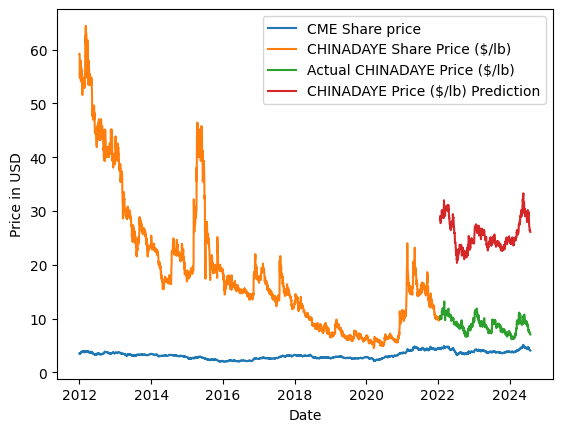

1.935555073008535

In [90]:

y_pred = linear_regression(train, test, "cme_close", "CHINADAYE_close")

plot_linear_regression(train, test, "cme_close", "CHINADAYE_close", y_pred)

calculate_mean_absolute_percentage_error(test, "CHINADAYE_close", y_pred)

C:\Users\jongi\AppData\Local\Temp\ipykernel_33148\2706717093.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # Choose a colormap with 10 distinct colors


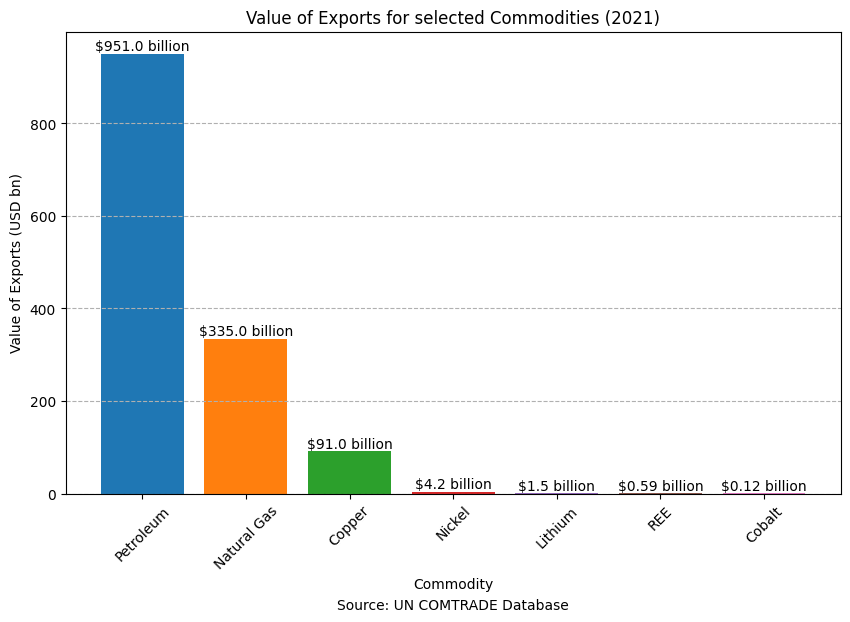

In [91]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Import colormap library

# Data
data = {
    "Petroleum": 951,
    "Natural Gas": 335,
    "Copper": 91,
    "Nickel": 4.2,
    "Lithium": 1.5,
    "REE": 0.59,
    "Cobalt": 0.12
}

# Extract commodities and values
commodities = list(data.keys())
values = list(data.values())

# Create a colormap for visually distinct colors
cmap = cm.get_cmap('tab10')  # Choose a colormap with 10 distinct colors

# Create bar chart with different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(commodities, values, color=cmap(range(len(commodities))))  # Assign colors from colormap

# Label each bar with its value in billion dollars with dollar signs
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'${height} billion', xy=(bar.get_x() + bar.get_width() / 2, height),
                 ha='center', va='bottom')

plt.xlabel("Commodity")
plt.ylabel("Value of Exports (USD bn)")
plt.title("Value of Exports for selected Commodities (2021)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Add source at the bottom
plt.text(0.5, -0.25, 'Source: UN COMTRADE Database', ha='center', transform=plt.gca().transAxes)

plt.show()

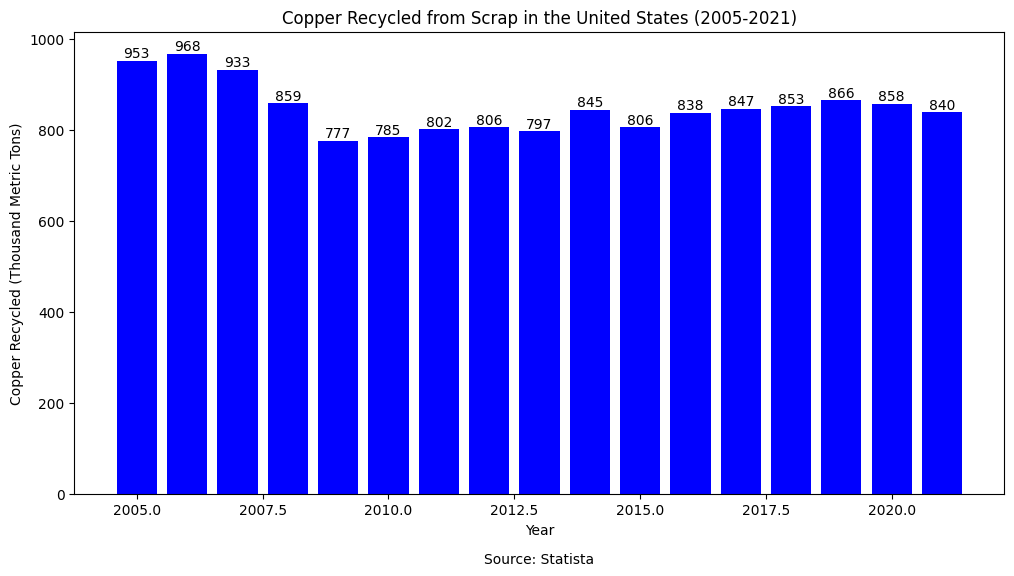

In [92]:
import matplotlib.pyplot as plt

# Data from the table
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
copper_recycled = [953, 968, 933, 859, 777, 785, 802, 806, 797, 845, 806, 838, 847, 853, 866, 858, 840]

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(years, copper_recycled, color='blue')

# Add data labels to each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


# Add labels and title
plt.xlabel('Year')
plt.ylabel('Copper Recycled (Thousand Metric Tons)')
plt.title('Copper Recycled from Scrap in the United States (2005-2021)')
plt.text(0.5, -0.15, 'Source: Statista', ha='center', transform=plt.gca().transAxes)


# Show the plot
plt.show()

In [93]:
# predictive power is only effective on some companies 

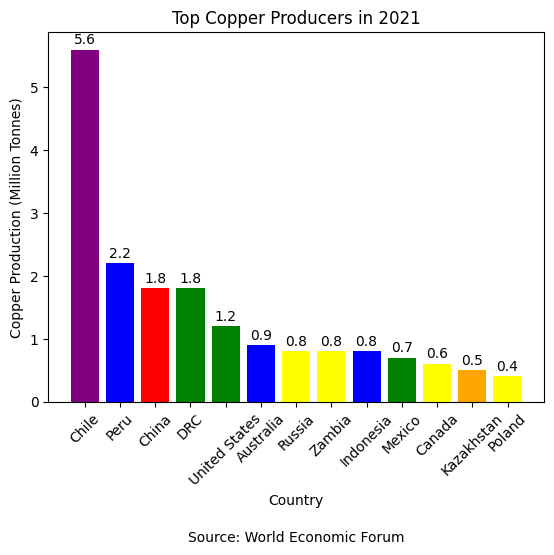

In [94]:
import matplotlib.pyplot as plt
import random

# Data
data = {
    "Chile": 5.6,
    "Peru": 2.2,
    "China": 1.8,
    "DRC": 1.8,
    "United States": 1.2,
    "Australia": 0.9,
    "Russia": 0.8,
    "Zambia": 0.8,
    "Indonesia": 0.8,
    "Mexico": 0.7,
    "Canada": 0.6,
    "Kazakhstan": 0.5,
    "Poland": 0.4,
}

# Sort data by descending values
data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Create bar chart with random colors
colors = [random.choice(['blue', 'green', 'red', 'orange', 'purple', 'yellow']) for _ in range(len(data))]
bars = plt.bar(data.keys(), data.values(), color=colors)

# Label each bar with value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 2),  # 2 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.title("Top Copper Producers in 2021")
plt.xlabel("Country")
plt.ylabel("Copper Production (Million Tonnes)")
plt.xticks(rotation=45)
plt.text(0.5, -0.38, 'Source: World Economic Forum', ha='center', transform=plt.gca().transAxes)
# Remove grid lines
plt.grid(False)
plt.show()

                            OLS Regression Results                            
Dep. Variable:       SHFE price_close   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     6119.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:00:22   Log-Likelihood:                -25077.
No. Observations:                3676   AIC:                         5.021e+04
Df Residuals:                    3650   BIC:                         5.037e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3895.7218     58.861     

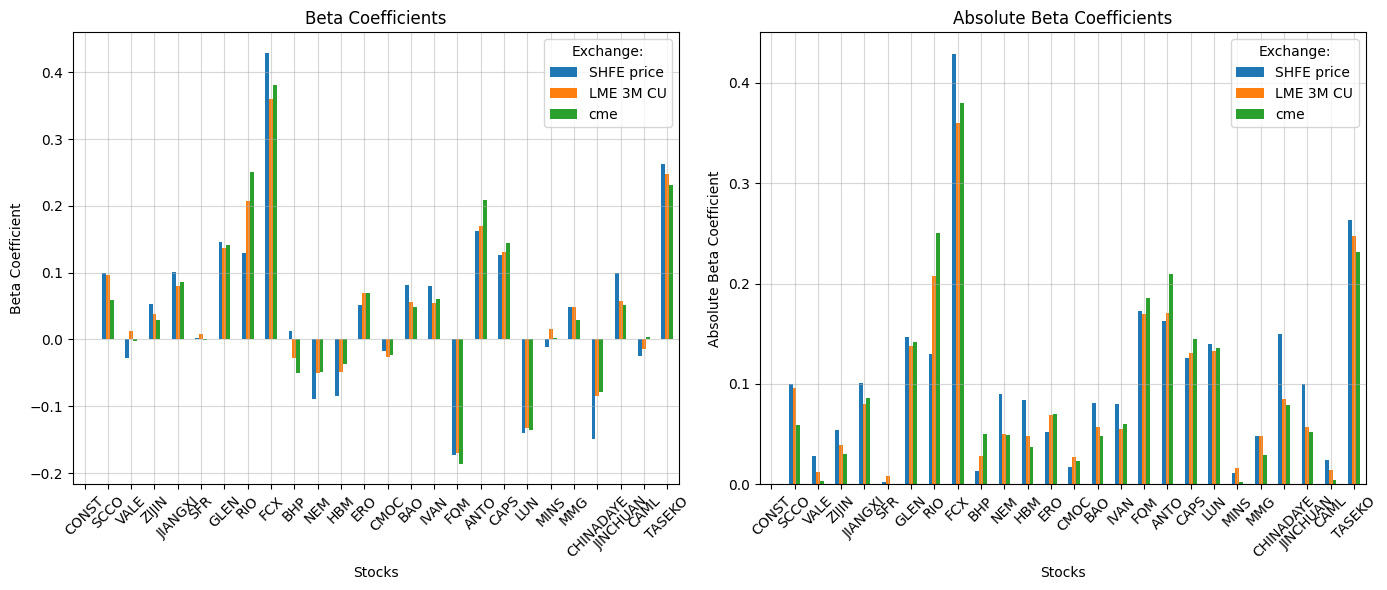

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Assuming train and test dataframes are already defined and mv_regression is available

summary = []
models = []
betas = []
Xs = [
    "scco_adj_close",
    "vale_adj_close",
    "Zijin_close",
    "Jiangxi_close",
    "SFR_close",
    "Glen_close",
    "rio_adj_close",
    "fcx_adj_close",
    "bhp_adj_close",
    "nem_adj_close",
    "hbm_adj_close",
    "ero_adj_close",
    "CMOC_close",
    "BAO_close",
    "IVAN_close",
    "FQM_close",
    "ANTO_close",
    "CAPS_close",
    "LUN_close",
    "MINS_close",
    "MMG_close",
    "CHINADAYE_close",
    "Jinchuan_close",
    "CAML_price",
    "Taseko_close",
]

for stock_id in ["SHFE price_close", "LME 3M CU_close", "cme_close"]:
    model, y_pred = mv_regression(train, test, Xs, stock_id)
    mape = (
        ((test[stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id])
        .abs()
        .mean()
        .item()
    )
    mpe = (
        ((test[stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id]).mean().item()
    )

    omnibus_test = sm.stats.omni_normtest(model.resid)
    jb_test = sm.stats.jarque_bera(model.resid)

    summary.append(
        {
            "stock_id": stock_id,
            "MAPE": mape,
            "R2": model.rsquared,
            "P_value": model.f_pvalue,
            "F_stat": model.fvalue,
            "Skew": model.resid.skew(),
            "Kurtosis": model.resid.kurtosis(),
            "Durbin_Watson": sm.stats.durbin_watson(model.resid),
            "Omnibus": omnibus_test[0],  # Omnibus test statistic
            "Omnibus_pvalue": omnibus_test[1],  # p-value for the Omnibus test
            "Jarque_Bera": jb_test[0],  # Jarque-Bera test statistic
            "Jarque_Bera_pvalue": jb_test[1],  # p-value for the Jarque-Bera test
            "MPE": mpe,
        }
    )

    # Now we calculate the standardised beta coefficients
    X_orig = train[Xs]
    X_scaled = (X_orig - X_orig.mean()) / X_orig.std()
    X_scaled = sm.add_constant(X_scaled)
    y_scaled = (train[stock_id] - train[stock_id].mean()) / train[stock_id].std()

    # Now we run the regression
    model_scaled = sm.OLS(y_scaled, X_scaled).fit()

    # Now we can extract the beta coefficients
    beta = model_scaled.params
    betas.append(
        {"stock_id": stock_id, **{col: beta[col].item() for col in X_scaled.columns}}
    )

reg_df_1 = pd.DataFrame(summary)

# Print the summary DataFrame
print("Summary of Regression Results:")
print(reg_df_1.to_string(index=False))

# Now we can calculate the standardised beta coefficients
beta_df = pd.DataFrame(betas)

# Print the beta coefficients DataFrame
print("\nStandardised Beta Coefficients:")
print(beta_df.to_string(index=False))

# Plot beta_df as bar graph with columns as x axis and beta values as y axis, each stock as a different color
# Other plot absolute beta values
# Change series names with fn lambda x: x.split("_")[0]

beta_df_g = beta_df.copy()
beta_df_g["stock_id"] = beta_df_g["stock_id"].apply(lambda x: x.split("_")[0])
beta_df_g = beta_df_g.set_index("stock_id")
beta_df_g.columns = beta_df_g.columns.map(lambda x: x.split("_")[0])
beta_df_g = beta_df_g.T

fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted figsize for better display

# Plot the beta coefficients
beta_df_g.plot(kind="bar", ax=axs[0])
axs[0].set_title("Beta Coefficients")
axs[0].set_ylabel("Beta Coefficient")
axs[0].set_xlabel("Stocks")
axs[0].legend(title="Exchange:", bbox_to_anchor=(1, 1))
axs[0].grid(True, which="both", ls="-", alpha=0.5)

axs[0].set_xticklabels([label.get_text().upper() for label in axs[0].get_xticklabels()], rotation=45)

# Convert x-tick labels to uppercase
axs[0].set_xticklabels([label.get_text().upper() for label in axs[0].get_xticklabels()])

# Plot the absolute beta coefficients
beta_df_g.apply(lambda x: x.abs()).plot(kind="bar", ax=axs[1])
axs[1].set_title("Absolute Beta Coefficients")
axs[1].set_ylabel("Absolute Beta Coefficient")
axs[1].set_xlabel("Stocks")
axs[1].legend(title="Exchange:", bbox_to_anchor=(1, 1))
axs[1].grid(True, which="both", ls="-", alpha=0.5)

axs[1].set_xticklabels([label.get_text().upper() for label in axs[1].get_xticklabels()], rotation=45)

# Convert x-tick labels to uppercase
axs[1].set_xticklabels([label.get_text().upper() for label in axs[1].get_xticklabels()])

plt.tight_layout()
plt.show()



In [96]:


summary = []
models = []
Xs = ["scco_adj_close", "vale_adj_close", "Zijin_close", "Jiangxi_close", "SFR_close", "Glen_close", "rio_adj_close", "fcx_adj_close", "bhp_adj_close", "nem_adj_close", "hbm_adj_close", "ero_adj_close", "CMOC_close", "BAO_close", "IVAN_close", "FQM_close", "ANTO_close", "CAPS_close", "LUN_close", "MINS_close", "MMG_close", "CHINADAYE_close", "Jinchuan_close", "CAML_price", "Taseko_close"]

for stock_id in ["SHFE price_close", "LME 3M CU_close", "cme_close"]:
    

    model, y_pred = mv_regression(train, test, Xs, stock_id)
    mape = ((test [stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id]).abs().mean().item()
    mpe = ((test [stock_id].to_numpy() - y_pred.to_numpy()) / test[stock_id]).mean().item()


    omnibus_test = sm.stats.omni_normtest(model.resid)
    jb_test = sm.stats.jarque_bera(model.resid)

    summary.append({
        "stock_id": stock_id,
        "MAPE": mape,
        'R2': model.rsquared,
        'P_value': model.f_pvalue,
        'F_stat': model.fvalue,
        'Skew': model.resid.skew(),
        'Kurtosis': model.resid.kurtosis(),
        'Durbin_Watson': sm.stats.durbin_watson(model.resid),
        'Omnibus': omnibus_test[0],  # Omnibus test statistic
        'Omnibus_pvalue': omnibus_test[1],  # p-value for the Omnibus test
        'Jarque_Bera': jb_test[0],  # Jarque-Bera test statistic
        'Jarque_Bera_pvalue': jb_test[1],  # p-value for the Jarque-Bera test
        'MPE': mpe
    })

reg_df_1 = pd.DataFrame(summary)
reg_df_1.to_clipboard()
reg_df_1 


                            OLS Regression Results                            
Dep. Variable:       SHFE price_close   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     6119.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:00:22   Log-Likelihood:                -25077.
No. Observations:                3676   AIC:                         5.021e+04
Df Residuals:                    3650   BIC:                         5.037e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3895.7218     58.861     

,stock_id,MAPE,R2,P_value,F_stat,Skew,Kurtosis,Durbin_Watson,Omnibus,Omnibus_pvalue,Jarque_Bera,Jarque_Bera_pvalue,MPE
0,SHFE price_close,0.163444,0.976695,0.0,6118.618409,-0.292781,0.257010,0.092595,58.857045,1.657124e-13,62.437135,2.766613e-14,-0.153127
1,LME 3M CU_close,0.156370,0.982510,0.0,8201.471424,-0.163370,-0.164040,0.098819,20.943847,2.832054e-05,20.531236,3.480957e-05,-0.150253
2,cme_close,0.155142,0.982225,0.0,8067.988494,-0.079020,-0.187054,0.114342,10.198094,6.102560e-03,9.260852,9.750605e-03,-0.147917


                            OLS Regression Results                            
Dep. Variable:             shfe_close   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     2144.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:09:39   Log-Likelihood:                -31141.
No. Observations:                3676   AIC:                         6.229e+04
Df Residuals:                    3674   BIC:                         6.230e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5681.2060     48.880    116.229

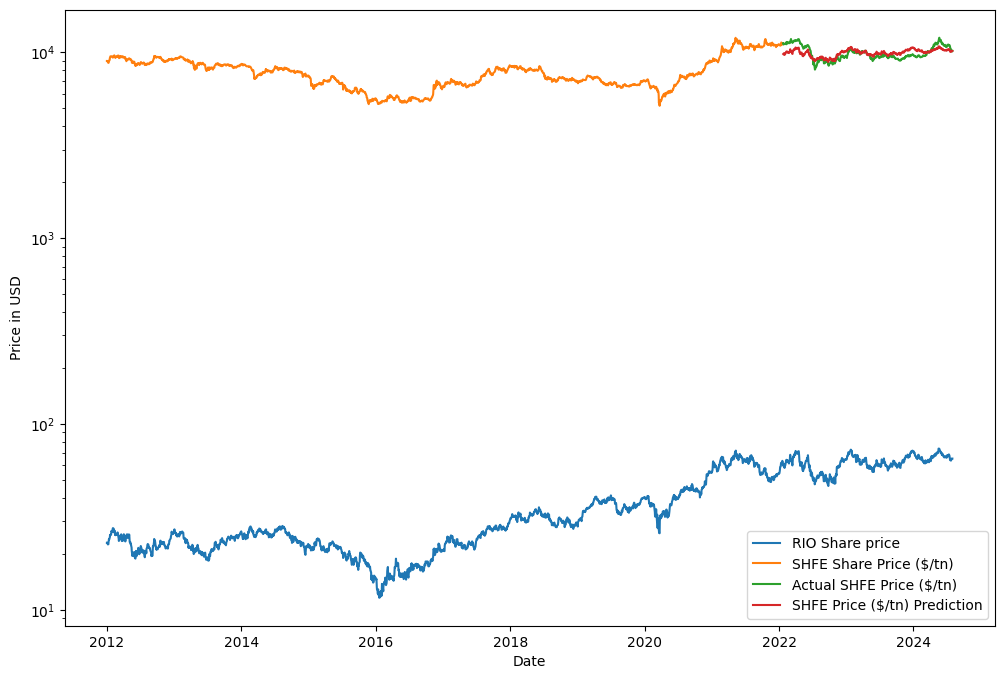

0.054663360643248116

In [101]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def linear_regression(train, test, x_col, y_col):
    X = sm.add_constant(train[x_col])
    model = sm.OLS(train[y_col], X).fit()
    print(model.summary())
    return model.predict(sm.add_constant(test[x_col]))

def plot_linear_regression(train, test, x_col, y_col, y_pred):
    x_lab = x_col.split("_")[0].upper()
    y_lab = y_col.split("_")[0].upper()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df_final["date"], df_final[x_col], label=f"{x_lab} Share price")
    ax.plot(train["date"], train[y_col], label=f"{y_lab} Share Price ($/tn)")
    ax.plot(test["date"], test[y_col], label=f"Actual {y_lab} Price ($/tn)")
    ax.plot(test["date"], y_pred, label=f"{y_lab} Price ($/tn) Prediction")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price in USD")
    ax.set_yscale("log")
    ax.legend()
    plt.show()

def calculate_mean_absolute_percentage_error(data, y_col, y_pred):
    return (
        ((y_pred - data[y_col]) / data[y_col])
        .abs()
        .mean()
        .item()
    )

y_pred = linear_regression(train, test, "rio_adj_close", "shfe_close")
plot_linear_regression(train, test, "rio_adj_close", "shfe_close", y_pred)
calculate_mean_absolute_percentage_error(test, "shfe_close", y_pred)

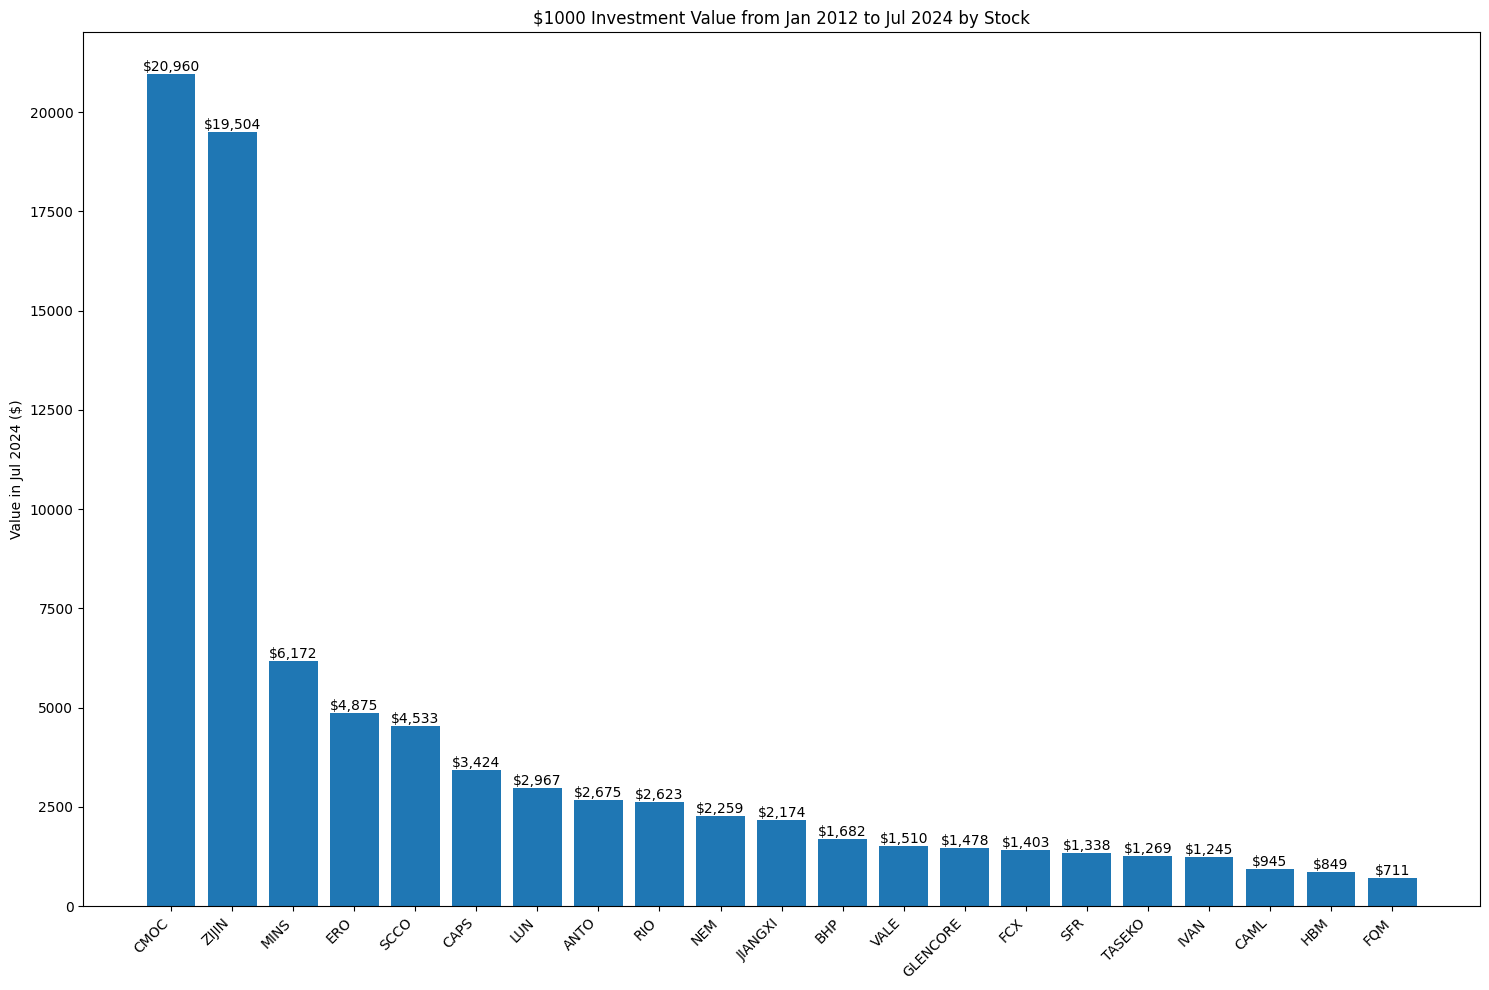

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tickers = ['SCCO', 'VALE', 'ZIJIN', 'JIANGXI', 'SFR', 'GLENCORE', 'RIO', 'FCX', 'BHP', 
           'NEM', 'HBM', 'ERO', 'CMOC', 'IVAN', 'FQM', 'ANTO', 'CAPS', 'LUN', 'MINS', 'CAML', 'TASEKO']
values = [4533, 1510, 19504, 2174, 1338, 1478, 2623, 1403, 1682, 2259, 849, 4875, 20960, 1245, 711, 
          2675, 3424, 2967, 6172, 945, 1269]

# Sort the data by value in descending order
sorted_indices = np.argsort(values)[::-1]
tickers = [tickers[i] for i in sorted_indices]
values = [values[i] for i in sorted_indices]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the bars
bars = ax.bar(range(len(tickers)), values)

# Customize the plot
ax.set_ylabel('Value in Jul 2024 ($)')
ax.set_title('$1000 Investment Value from Jan 2012 to Jul 2024 by Stock')
ax.set_xticks(range(len(tickers)))
ax.set_xticklabels(tickers, rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,}',
            ha='center', va='bottom', rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()